# River Tree

An example workflow for gathering NHD Plus data and generating a tree.  This tree can then be iterated over to accumulate data.  Braided systems are merged into a single reach, and the system is simplified relative to NHD Plus's raw format.

This type of workflow is useful for setting up stream network models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import watershed_workflow
import watershed_workflow.crs
import watershed_workflow.source_list
import watershed_workflow.config
import watershed_workflow.ui
import watershed_workflow.utils

watershed_workflow.ui.setup_logging(1,None)
crs = watershed_workflow.crs.default_crs


In [3]:
# open a shapefile for use here
shpfile = os.path.join('Coweeta', 'input_data', 'coweeta_basin.shp')
shp = watershed_workflow.getShapes(shpfile, crs=crs)
shp

,AREA,PERIMETER,CWTBASINNA,CWTBASIN_1,BASIN_CODE,SPOT,LABEL,geometry
0,1.626020e+07,17521.768,2,1,1,-9999,Coweeta Hydrologic Lab,"POLYGON ((1130750.667 1409230.854, 1130791.743..."


In [4]:
# find the rivers in this shape
reaches = watershed_workflow.getShapesByGeometry(watershed_workflow.source_list.hydrography_sources['NHDv2.1'],
                                                 shp.geometry.iloc[0], shp.crs, crs)
reaches.geometry = reaches.geometry.apply(shapely.ops.linemerge)
reaches
#for c in reaches.columns:
#    print(c)

,geometry,comid,fdate,resolution,gnis_id,gnis_name,lengthkm,reachcode,flowdir,wbareacomi,...,rpuid,vpuid,enabled,geometry_ca,gridcode,featureid,sourcefc,areasqkm_ca,shape_length_ca,shape_area
ID,,,,,,,,,,,,,,,,,,,,,
19736291,"LINESTRING Z (1132445.584 1408537.306 0, 11324...",19736291,1999-09-07T04:00:00Z,Medium,1015479,Shope Fork,1.522,06010202000369,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1132694.981 1408095.022, 11327...",2774102,19736291,NHDFlowline,1.928397,0.061415,0.000191
19736305,"LINESTRING Z (1133712.415 1408561.857 0, 11338...",19736305,1999-09-07T04:00:00Z,Medium,1010529,Coweeta Creek,2.771,06010202000091,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1134435.01 1407975.003, 113438...",2773590,19736305,NHDFlowline,2.949338,0.081972,0.000291
19736307,"LINESTRING Z (1133252.709 1407838.903 0, 11332...",19736307,1999-09-07T04:00:00Z,Medium,1010529,Coweeta Creek,0.897,06010202000092,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1133565.006 1406834.978, 11335...",2773589,19736307,NHDFlowline,1.066977,0.048155,0.000105
19736315,"LINESTRING Z (1131251.957 1406995.258 0, 11312...",19736315,1999-09-07T04:00:00Z,Medium,1010615,Cunningham Creek,2.107,06010202000371,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1130565.011 1406685.014, 11305...",2773984,19736315,NHDFlowline,1.711001,0.063858,0.000169
19736317,"LINESTRING Z (1130537.001 1406775.771 0, 11306...",19736317,1999-09-07T04:00:00Z,Medium,1015479,Shope Fork,3.062,06010202000370,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1130084.983 1406295.04, 113011...",2773997,19736317,NHDFlowline,4.827050,0.104943,0.000477
19736355,"LINESTRING Z (1130687.925 1405227.347 0, 11307...",19736355,1999-09-07T04:00:00Z,Medium,1010529,Coweeta Creek,4.021,06010202000093,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1130175.03 1405394.996, 113013...",2773599,19736355,NHDFlowline,2.476326,0.103959,0.000245
19736357,"LINESTRING Z (1131225.581 1405291.462 0, 11312...",19736357,2009-03-15T04:00:00Z,Medium,1011984,Henson Creek,3.561,06010202000372,With Digitized,0,...,06a,06,1,"MULTIPOLYGON (((1131375.013 1404734.979, 11313...",2773895,19736357,NHDFlowline,3.774987,0.090128,0.000373


In [5]:
# make the global tree
rivers = watershed_workflow.river_tree.createRiverTrees(reaches, method='hydroseq')

# check that only one tree was formed
assert(len(rivers) == 1)
river = rivers[0]

<Axes: >

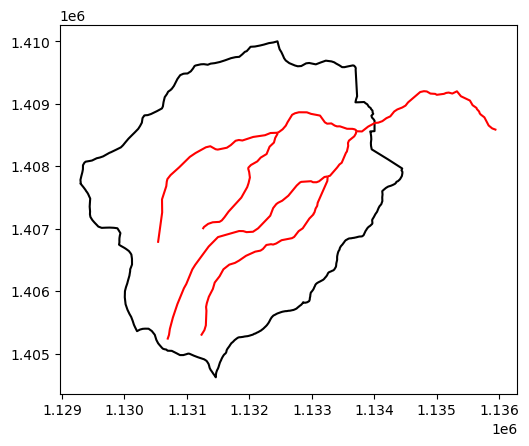

In [6]:
ax = shp.boundary.plot(color='k')
reaches.plot(color='r', ax=ax)


In [7]:
print('NAME: length')
print('-------------')
gnis_name = 'GNIS_Name' if 'GNIS_Name' in river else 'gnis_name'

for r in river:
    print(f"{r.properties[gnis_name]}: {r.properties['shape_length']}")

NAME: length
-------------
Coweeta Creek: 0.0288714963622201
Shope Fork: 0.0159618921169526
Cunningham Creek: 0.02117534397197
Shope Fork: 0.0312003700558532
Coweeta Creek: 0.00886730048267512
Coweeta Creek: 0.0408512091814329
Henson Creek: 0.035737774509713
